# REST API - Health and Performance Monitoring Deep Dive

In [4]:
import requests as r
import urllib3
import json
import time

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

base_url = "https://9.155.108.201/scalemgmt/v2"
auth_data = ("admin","admin001")
headers = {'content-type' : 'application/json', 'accepts' : 'application/json'}

def printJson(res):
    for line in res.text.split("\n"):
        print line
    #output = json.dumps(res.json(), sort_keys=True, indent=4)
    #for line in output.split("\n"):
    #    print line
        
def get(url, params=None,printResult=True, printRequest=True):
    if printRequest:
        print "GET " + base_url + url
    res = r.get(base_url + url, auth=auth_data, verify=False, headers=headers, params=params)
    if printResult:
        printJson(res)
    return res

def delete(url, printResult=True, printRequest=True):
    if printRequest:
        print "DELETE " + base_url + url
    res = r.delete(base_url + url, auth=auth_data, verify=False, headers=headers)
    if printResult:
        printJson(res)
    return res
    
def post(url, data, printResult=True, printRequest=True):
    if printRequest:
        print "POST " + base_url + url
    res = r.post(base_url + url, auth=auth_data, verify=False, json=data, headers=headers)
    if printResult:
        printJson(res)
    return res

def put(url, data, printResult=True, printRequest=True):
    if printRequest:
        print "PUT " + base_url + url
    res = r.put(base_url + url, auth=auth_data, verify=False, json=data, headers=headers)
    if printResult:
        printJson(res)
    return res

def getJobId(res):
    return str(res.json()['jobs'][0]['jobId'])
    
def waitForJob(jobId, maxRetries=10):
    completed = False
    retries = 0
    status = ""
    while not completed and retries < maxRetries:
        time.sleep(1)
        res = get("/jobs/" + str(jobId), printResult=False)
        status = str(res.json()['jobs'][0]['completed'])
        completed = status != "N/A"
        if not completed:
            print "Job not yet completed, status: " + status
        retries += 1
    return (completed, res)

def waitForJobResult(res, maxRetries=10):
    jobId = getJobId(res)
    return waitForJob(jobId, maxRetries)



<img src="REST_API_Health_and_Performance_Monitoring.png">

<br><br><br><br>
# Health Monitoring
<br><br><br>

<img src="Health_Architecture_1.png"/>
<img src="Health_Architecture_2.png"/>
<img src="Health_Architecture_3.png"/>

## All the data available in "mmhealth" is available through the REST API as well

In [ ]:
!ssh os-21 mmhealth node show

In [ ]:
!ssh os-21 mmhealth node show CES -N cesNodes

## With the REST API the data is retrieved directly from a database -> No command is executed on the cluster

## Retrieving all the component states from one node

In [5]:
get("/nodes/os-11/health/states")

GET https://9.155.108.201/scalemgmt/v2/nodes/os-11/health/states
{
  "states" : [ {
    "activeSince" : "2019-03-15 10:49:08,166",
    "component" : "FILEAUDITLOG",
    "entityName" : "os-11.novalocal",
    "entityType" : "NODE",
    "oid" : 7870,
    "reportingNode" : "os-11.novalocal",
    "state" : "CHECKING"
  }, {
    "activeSince" : "2019-03-15 10:49:08,482",
    "component" : "THRESHOLD",
    "entityName" : "os-11.novalocal",
    "entityType" : "NODE",
    "oid" : 7875,
    "reportingNode" : "os-11.novalocal",
    "state" : "HEALTHY"
  }, {
    "activeSince" : "2019-03-15 10:49:10,229",
    "component" : "NETWORK",
    "entityName" : "os-11.novalocal",
    "entityType" : "NODE",
    "oid" : 7878,
    "reportingNode" : "os-11.novalocal",
    "state" : "HEALTHY"
  }, {
    "activeSince" : "2019-03-15 10:49:10,295",
    "component" : "NETWORK",
    "entityName" : "eth0",
    "entityType" : "NIC",
    "oid" : 7879,
    "parentName" : "os-11.novalocal",
    "reportingNode" : "os-11.n

<Response [200]>

## Retrieve only the component, state and entity name from one node

In [90]:
get("/nodes/os-21/health/states?fields=component,state,entityName")

GET https://9.155.108.247/scalemgmt/v2/nodes/os-21/health/states?fields=component,state,entityName
{
  "states" : [ {
    "component" : "DISK",
    "entityName" : "disk2",
    "state" : "HEALTHY"
  }, {
    "component" : "NETWORK",
    "entityName" : "os-21.novalocal",
    "state" : "HEALTHY"
  }, {
    "component" : "THRESHOLD",
    "entityName" : "os-21.novalocal",
    "state" : "HEALTHY"
  }, {
    "component" : "DISK",
    "entityName" : "disk5",
    "state" : "HEALTHY"
  }, {
    "component" : "DISK",
    "entityName" : "disk1",
    "state" : "HEALTHY"
  }, {
    "component" : "PERFMON",
    "entityName" : "os-21.novalocal",
    "state" : "HEALTHY"
  }, {
    "component" : "FILEAUDITLOG",
    "entityName" : "gpfs0",
    "state" : "HEALTHY"
  }, {
    "component" : "DISK",
    "entityName" : "disk3",
    "state" : "HEALTHY"
  }, {
    "component" : "DISK",
    "entityName" : "disk4",
    "state" : "HEALTHY"
  }, {
    "component" : "THRESHOLD",
    "entityName" : "MemFree_Rule",
  

<Response [200]>

## Retrieve all DEGRADED components from all nodes

In [99]:
get("/nodes/:all:/health/states?fields=component,state,entityName&filter=state=DEGRADED")

GET https://9.155.108.247/scalemgmt/v2/nodes/:all:/health/states?fields=component,state,entityName&filter=state=DEGRADED
{
  "states" : [ {
    "component" : "CESNETWORK",
    "entityName" : "os-23.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "SMB",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "CES",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "NFS",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "NODE",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "AUTH",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  } ],
  "status" : {
    "code" : 200,
    "message" : "The request finished successfully."
  }
}


<Response [200]>

## Retrieve all DEGRADED components from all CES nodes

In [101]:
get("/nodes/cesNodes/health/states?fields=component,state,entityName&filter=state=DEGRADED")

GET https://9.155.108.247/scalemgmt/v2/nodes/cesNodes/health/states?fields=component,state,entityName&filter=state=DEGRADED
{
  "states" : [ {
    "component" : "CESNETWORK",
    "entityName" : "os-23.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "SMB",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "CES",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "NFS",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "NODE",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  }, {
    "component" : "AUTH",
    "entityName" : "os-22.novalocal",
    "state" : "DEGRADED"
  } ],
  "status" : {
    "code" : 200,
    "message" : "The request finished successfully."
  }
}


<Response [200]>

## Retrieve all ERROR events from all the nodes

In [94]:
get("/nodes/:all:/health/events?filter=severity=ERROR")

GET https://9.155.108.247/scalemgmt/v2/nodes/:all:/health/events?filter=severity=ERROR
{
  "events" : [ {
    "activeSince" : "2018-04-09 11:39:01,000",
    "component" : "AUTH",
    "description" : "The external Active Directory Service (ADS) is unresponsive",
    "entityName" : "os-22.novalocal",
    "entityType" : "NODE",
    "message" : "external ADS server is unresponsive",
    "name" : "ads_down",
    "oid" : 89,
    "reportingNode" : "os-22.novalocal",
    "severity" : "ERROR",
    "state" : "DEGRADED",
    "type" : "STATE_CHANGE",
    "userAction" : "Verify network connection and check that ADS server(s) are operational"
  }, {
    "activeSince" : "2018-04-09 11:38:01,000",
    "component" : "GUI",
    "description" : "The GUI service is down",
    "entityName" : "os-22.novalocal",
    "entityType" : "NODE",
    "message" : "GUI service should be started and is stopped.",
    "name" : "gui_down",
    "oid" : 105,
    "reportingNode" : "os-22.novalocal",
    "severity" : "ERROR"

<Response [200]>

## Retrieve all WARNING events from all CES nodes

In [102]:
get("/nodes/cesNodes/health/events?filter=severity=WARNING")

GET https://9.155.108.247/scalemgmt/v2/nodes/cesNodes/health/events?filter=severity=WARNING
{
  "events" : [ {
    "activeSince" : "2018-04-03 15:42:56,360",
    "component" : "CESIP",
    "description" : "Check of the CES IP assignment state returned an unknown result. This might be a temporary issue, like a timeout during the check procedure",
    "entityName" : "os-22.novalocal",
    "entityType" : "NODE",
    "message" : "The Spectrum Scale CES IP assignment monitor could not be executed. This could be a timeout issue",
    "name" : "ces_ips__warn",
    "oid" : 55,
    "reportingNode" : "os-22.novalocal",
    "severity" : "WARNING",
    "state" : "UNKNOWN",
    "type" : "NOTICE",
    "userAction" : "Find potential issues for this kind of failure in the /var/adm/ras/mmsysmonitor.log file"
  }, {
    "activeSince" : "2018-04-11 10:03:49,074",
    "component" : "CESIP",
    "description" : "Check of the CES IP assignment state returned an unknown result. This might be a temporary issu

<Response [200]>

<br><br><br><br>
# Performance Monitoring
<br><br><br>

<img src="Zimon_Architecture_1.png">

<img src="Zimon_Architecture_2.png">

<img src="Zimon_Architecture_3.png">

## Displaying the active sensor configuration

In [79]:
get("/perfmon/sensors?fields=period,description,restrict")

GET https://9.155.108.247/scalemgmt/v2/perfmon/sensors?fields=period,description,restrict
{
  "sensorConfig" : [ {
    "description" : "Collects the load values which is the length of the runqueue.",
    "period" : 1,
    "restrict" : [ ],
    "sensorName" : "Load"
  }, {
    "description" : "Collects  statistics on the account layer of the object protocol.",
    "period" : 0,
    "restrict" : [ ],
    "sensorName" : "SwiftAccount"
  }, {
    "description" : "",
    "period" : 0,
    "restrict" : [ ],
    "sensorName" : "GPFSvFLUSH"
  }, {
    "description" : "Collects CTDB stats.  This should be enabled to enable FTDC for clusters running the SMB protocol.",
    "period" : 10,
    "restrict" : [ ],
    "sensorName" : "CTDBStats"
  }, {
    "description" : "",
    "period" : 0,
    "restrict" : [ ],
    "sensorName" : "GPFSIOC"
  }, {
    "description" : "Collects I/O statistics for pdisks on GNR based systems.",
    "period" : 10,
    "restrict" : [ "nsdNodes" ],
    "sensorName" : "G

<Response [200]>

## The Zimon query language

### On the shell

In [82]:
!ssh os-21 'echo "get metrics cpu_user bucket_size 1 last 10" | /opt/IBM/zimon/zc 127.0.0.1'

##########################################################
Info : GPFS modified Rhel72 Client :  root -->  Passw0rd
########################################################## 
1:	os-21.novalocal|CPU|cpu_user
2:	os-22.novalocal|CPU|cpu_user
3:	os-23.novalocal|CPU|cpu_user
4:	os-24.novalocal|CPU|cpu_user
Row	Timestamp		cpu_user	cpu_user	cpu_user	cpu_user	
1	2018-04-13 21:14:25	6.600000	1.010000	0.510000	0.000000
2	2018-04-13 21:14:26	1.010000	0.000000	0.500000	0.000000
3	2018-04-13 21:14:27	1.010000	0.510000	0.510000	0.000000
4	2018-04-13 21:14:28	1.000000	0.000000	1.000000	0.000000
5	2018-04-13 21:14:29	1.490000	0.500000	0.510000	0.000000
6	2018-04-13 21:14:30	1.010000	1.000000	0.500000	0.000000
7	2018-04-13 21:14:31	1.000000	0.000000	1.510000	0.000000
8	2018-04-13 21:14:32	3.540000	0.500000	1.010000	0.000000
9	2018-04-13 21:14:33	1.000000	1.000000	0.000000	0.000000
10	2018-04-13 21:14:34	1.510000	0.500000	11.060000	0.000000
.


In [83]:
!ssh os-21 'echo "get metrics cpu_user bucket_size 1 tstart '2018-04-13 21:00:00' tend '2018-04-13 21:00:30'" | /opt/IBM/zimon/zc 127.0.0.1'

##########################################################
Info : GPFS modified Rhel72 Client :  root -->  Passw0rd
########################################################## 
1:	os-21.novalocal|CPU|cpu_user
2:	os-22.novalocal|CPU|cpu_user
3:	os-23.novalocal|CPU|cpu_user
4:	os-24.novalocal|CPU|cpu_user
Row	Timestamp		cpu_user	cpu_user	cpu_user	cpu_user	
1	2018-04-13 21:00:01	2.500000	0.510000	1.010000	0.000000
2	2018-04-13 21:00:02	0.510000	0.500000	9.550000	0.000000
3	2018-04-13 21:00:03	1.010000	0.500000	1.000000	0.000000
4	2018-04-13 21:00:04	1.500000	0.500000	2.010000	0.000000
5	2018-04-13 21:00:05	0.510000	0.000000	1.000000	0.000000
6	2018-04-13 21:00:06	1.520000	1.010000	0.510000	0.000000
7	2018-04-13 21:00:07	1.000000	0.500000	8.040000	0.000000
8	2018-04-13 21:00:08	1.010000	0.500000	0.500000	1.500000
9	2018-04-13 21:00:09	0.510000	0.500000	0.500000	0.000000
10	2018-04-13 21:00:10	1.000000	0.500000	1.000000	0.000000
11	2018-04-13 21:00:11	0.510000	0.500000	0.510000	0.000000
12	2

In [84]:
!ssh os-21 'echo "get metrics cpu_user bucket_size 60 tstart '2018-04-13 20:00:00' tend '2018-04-13 21:00:00'" | /opt/IBM/zimon/zc 127.0.0.1'

##########################################################
Info : GPFS modified Rhel72 Client :  root -->  Passw0rd
########################################################## 
1:	os-21.novalocal|CPU|cpu_user
2:	os-22.novalocal|CPU|cpu_user
3:	os-23.novalocal|CPU|cpu_user
4:	os-24.novalocal|CPU|cpu_user
Row	Timestamp		cpu_user	cpu_user	cpu_user	cpu_user	
1	2018-04-13 20:01:00	4.744667	21.342200	3.373167	0.025000
2	2018-04-13 20:02:00	4.498500	18.907818	3.534333	0.033333
3	2018-04-13 20:03:00	3.298833	18.974423	3.471000	0.016667
4	2018-04-13 20:04:00	3.966833	20.296071	3.823500	0.025000
5	2018-04-13 20:05:00	4.686333	20.254182	3.340833	0.016667
6	2018-04-13 20:06:00	4.704333	28.285000	3.160000	0.025000
7	2018-04-13 20:07:00	4.232500	30.437273	3.583000	0.125500
8	2018-04-13 20:08:00	2.627167	22.791964	2.980167	0.025000
9	2018-04-13 20:09:00	2.927333	19.905556	3.032333	0.025000
10	2018-04-13 20:10:00	3.374000	18.226852	3.044333	0.108000
11	2018-04-13 20:11:00	5.729833	23.002000	3.553333	0.

### General format of a query

<b>Basic syntax:</b>
```
get metrics <metric_name> <bucket_size> <timespan>

get metrics cpu_user bucket_size 1 tstart '2018-04-13 21:00:00' tend '2018-04-13 21:00:30'
get metrics cpu_user bucket_size 60 last 10
```

<ul>
    <li><b>get</b> - can be ommitted for the REST API</li>
    <li><b>metric_name</b> - name of a metric, e.g. cpu_user, mem_memfree (see "topo -m" for available metrics)
    <li><b>tstart, tend</b> - a unix timestamp (seconds since 01/01/1970) or in human readable format</li>
    <li><b>last</b> - number of buckets that are returned</b></li>
    <li><b>bucket_size</b> - aggregation interval (aggregation depends on metric type -> avg, sum, ...)</li>
</ul>
<br><br>
<b>Advanced syntax elements:</b>
<ul>
    <li>Aggregates: <b>rate(netdev_bytes_r)</b> - other valid methods: sum, avg, max, min, rate (bytes/second)</li>
    <li>Filter: <b>from node=...</b> - filters the data per node</li>
    <li>Grouping: <b>sum(netdev_bytes_r) group by netdev_name</b> - sums the data per network adapter (eth0, eth1, ..) -> sum alone would sum the data of all adapters on all nodes (one column)</li>
<ul>

## Retrieving performance data using the REST API
<ul>
    <li>The Zimon query language is used, which is slightly different to what mmperfmon uses -> see KC</li>
    <br>
    <li>Query string must be URL encoded (space = %20): 
    <br><b>metrics cpu_user bucket_size 1 last 10</b> -> <b> metrics%20cpu_user%20bucket_size%201%20last%205</b></li>
    <br>
    <li>All Zimon metrics available, see <b>echo "topo -m" | /opt/IBM/zimon/zc 127.0.0.1</b></li>
    <br>
    <li style="color:red;">Be careful with queries that would return a lot (megabytes) of data!</li>    
</ul>

## Example: Retrieve the free memory of all nodes

In [71]:
import pandas as pd
from pandas import DataFrame
import datetime

# Retrieve the free memory in kbytes of all nodes of the last five hours
# choose a bucket_size of 60 seconds
query={'query':'metrics mem_memfree bucket_size 60 last ' + str(60*5)} # last five hours
res = get("/perfmon/data", params=query, printResult=False)

# transform the retrieved data so that a pandas DataFrame object can be created
perfData = res.json()["performanceData"]

columnHeaders = ["key", "tstamp", "date", "value"]
transformedData = []

for i,row in enumerate(perfData["rows"]):    
    for j,value in enumerate(row["values"]):
        key = perfData["legend"][j]["keys"][0]
        tstamp = row["tstamp"]
        date = datetime.datetime.fromtimestamp(int(tstamp))
        if value is not None:
            transformedData.append([key,tstamp,date,value/1000.0]) # divide by 1000 to get megabytes

# create the DataFrame object and print the retrieved data
df = DataFrame(transformedData,columns=columnHeaders)
df

GET https://9.155.108.247/scalemgmt/v2/perfmon/data


,key,tstamp,date,value
0,os-21.novalocal|Memory|mem_memfree,1523625120,2018-04-13 15:12:00,201.988
1,os-22.novalocal|Memory|mem_memfree,1523625120,2018-04-13 15:12:00,639.786
2,os-23.novalocal|Memory|mem_memfree,1523625120,2018-04-13 15:12:00,870.387
3,os-24.novalocal|Memory|mem_memfree,1523625120,2018-04-13 15:12:00,2005.300
4,os-21.novalocal|Memory|mem_memfree,1523625180,2018-04-13 15:13:00,200.923
5,os-22.novalocal|Memory|mem_memfree,1523625180,2018-04-13 15:13:00,640.897
6,os-23.novalocal|Memory|mem_memfree,1523625180,2018-04-13 15:13:00,866.082
7,os-24.novalocal|Memory|mem_memfree,1523625180,2018-04-13 15:13:00,2005.044
8,os-21.novalocal|Memory|mem_memfree,1523625240,2018-04-13 15:14:00,199.290
9,os-22.novalocal|Memory|mem_memfree,1523625240,2018-04-13 15:14:00,644.455


### Basic analysis of the data

In [73]:
import numpy as np

pd.pivot_table(df,index=["key",],values=["value"],
               aggfunc=[len,np.min,np.max,np.mean])

,len,amin,amax,mean
,value,value,value,value
key,,,,
os-21.novalocal|Memory|mem_memfree,300.0,135.853,789.806,331.162973
os-22.novalocal|Memory|mem_memfree,300.0,107.813,950.383,394.911623
os-23.novalocal|Memory|mem_memfree,299.0,431.763,1326.679,986.113582
os-24.novalocal|Memory|mem_memfree,300.0,2004.372,3303.344,3059.313323


### Plot the data per node

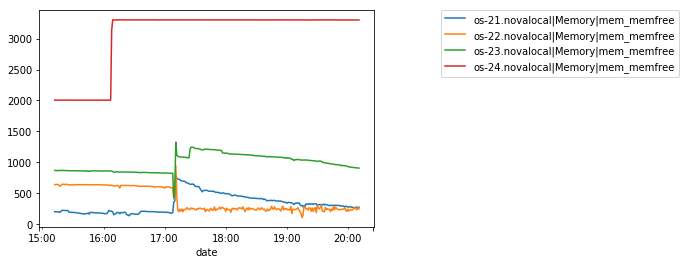

In [74]:
def pltPerfData(df):
    legend_entries = []
    ax = None
    for key, group in df.groupby("key"):
        if ax:
            df[df.key == key].plot(x="date",y=["value"], ax=ax)
        else:    
            ax = df[df.key == key].plot(x="date",y=["value"])
        legend_entries.append(key)
    ax.legend(legend_entries, bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

pltPerfData(df)